In [2]:
from pyprojroot.here import here

here()
import pandas as pd
import duckdb
from janitor import clean_names
df = clean_names(pd.read_excel(here(r"data/QuebrasJuntoInc.xlsx")))

C:\Users\Plancha\Desktop\pfacd\.pixi\envs\default\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\Plancha\Desktop\pfacd\.pixi\envs\default\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [15]:
# for Almada, caculate the time between events
almada = duckdb.query(r"""
  select 
    codigo_do_relatorio, concelho,
    strptime(data_do_incidente, '%Y-%m-%d') as data,
    strptime(data_do_incidente, '%Y-%m-%d') - lag(strptime(data_do_incidente, '%Y-%m-%d')) over (order by strptime(data_do_incidente, '%Y-%m-%d')) as diff
  from df where concelho = 'Almada'
  order by data
""").df()
# and data > '2017-12-31' and data < '2022-01-01' # deixar 2022 de fora para avaliacao
almadaa = duckdb.query(r"select * from almada where data > '2017-12-31' and data < '2022-01-01'").df()
almadaa

,codigo_do_relatorio,concelho,data,diff
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,85 days
1,EDPD_2018_JUN_T_20,Almada,2018-06-15,164 days
2,EDPD_2018_AGO_T_44,Almada,2018-08-30,76 days
3,EDPD_2018_SET_T_50,Almada,2018-09-10,11 days
4,EDPD_2019_JUN_T_36,Almada,2019-06-22,285 days
5,EDPD_2020_AGO_T_16,Almada,2020-08-13,418 days
6,EDPD_2020_AGO_T_20,Almada,2020-08-17,4 days
7,EDPD_2021_JAN_T_9,Almada,2021-01-08,144 days
8,EREDES_2021_MAR_T_25,Almada,2021-03-05,56 days
9,EREDES_2021_MAR_T_46,Almada,2021-03-15,10 days


In [18]:
# for all concelhos agora
concelhos = duckdb.query(r"""
  select 
    concelho,
    strptime(data_do_incidente, '%Y-%m-%d') as data,
    strptime(data_do_incidente, '%Y-%m-%d') - lag(strptime(data_do_incidente, '%Y-%m-%d')) over (partition by concelho order by strptime(data_do_incidente, '%Y-%m-%d')) as diff
  from df
  order by concelho, data
""").df()
concelhoss = duckdb.query(r"select * from concelhos where data > '2017-12-31' and data < '2022-01-01'").df()
concelhoss

,concelho,data,diff
0,Abrantes,2018-03-07,209 days
1,Abrantes,2019-06-07,457 days
2,Abrantes,2019-06-26,19 days
3,Abrantes,2019-07-26,30 days
4,Abrantes,2020-02-18,207 days
...,...,...,...
2062,Ílhavo,2020-03-15,19 days
2063,Ílhavo,2020-03-23,8 days
2064,Ílhavo,2020-04-18,26 days
2065,Ílhavo,2020-04-22,4 days


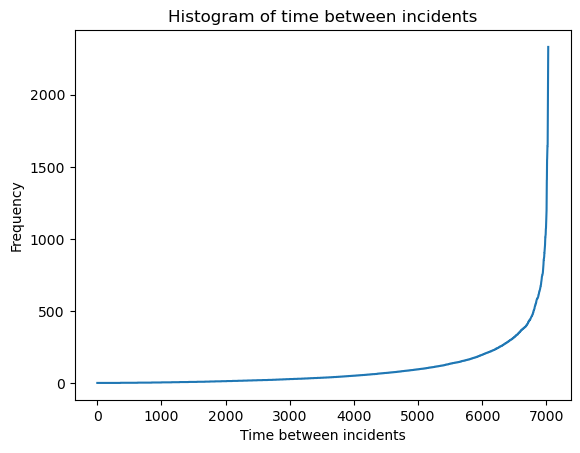

In [39]:
from datetime import timedelta

diffs = duckdb.query(r"""
  select * from concelhos where diff is not null order by diff
""").df()

# histogram with diffs
(diffs["diff"].dt.days).plot()
# add title and axis labels
import matplotlib.pyplot as plt
plt.title("Histogram of time between incidents")
plt.xlabel("Time between incidents")
plt.ylabel("Frequency")
plt.show()

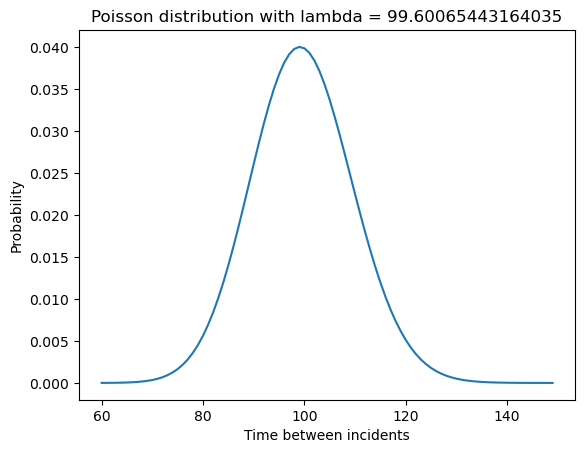

In [35]:

# poisson: span of 4 years 
avg = diffs["diff"].mean() / timedelta(days=1)
import numpy as np
import scipy.stats as stats
poisson = stats.poisson(avg)
x = np.arange(60, 150)
plt.plot(x, poisson.pmf(x))
plt.title("Poisson distribution with lambda = " + str(avg))
plt.xlabel("Time between incidents")
plt.ylabel("Probability")
plt.show()


<Axes: >

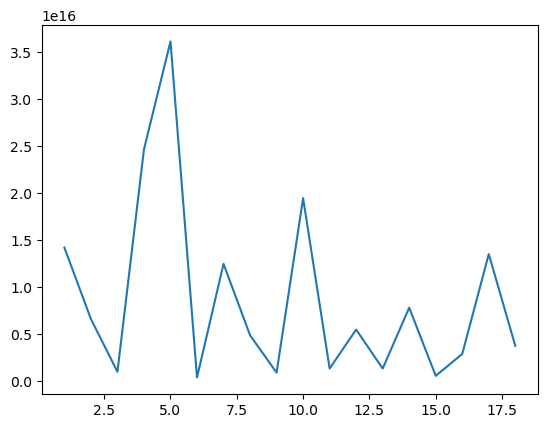